# Machine Learning Final Project
**Logan Dawes** - CS4783

The goal of this project is to develop a machine learning model for both classification and prediction tasks. The model will be designed to automatically infer missing ingredient lists and nutrient information for a given food item. This enables it to perform ingredient classification as well as nutrient estimation

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import warnings
warnings.filterwarnings('ignore')

### Load Dataset
In this step, we are going to first load all 4 datasets and preview thier first 5 rows to confirm that they have been loaded and plan a method of joining the tables into one unified dataset.

In [2]:
# Load datasets
food_data = pd.read_csv('food.csv')
branded_food_data = pd.read_csv('branded_food.csv')
nutrient_data = pd.read_csv('nutrient.csv')
food_nutrient_data = pd.read_csv('food_nutrient.csv')

## Step 1: Exploratory Data Analysis (EDA)

### Initial Data Exploration
First we perform a simple exploration of the features and first rows of each dataset to analyse a course of action.

In [44]:
# Display the first few rows of food data
pd.set_option('display.max_columns', None)  
food_data.head()

,fdc_id,data_type,description,food_category_id,publication_date,market_country,trade_channel,microbe_data
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."


In [4]:
# Display the first few rows of branded food data
branded_food_data.head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,...,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description,material_code
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,27000612323,Vegetable Oil,NaN,15.0,ml,1 Tbsp (15 ml),...,GDSN,NaN,2020-10-02,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,51000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",NaN,240.0,ml,Amount per serving,...,GDSN,NaN,2020-09-12,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,51000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",NaN,440.0,g,PER CONTAINER,...,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,51000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",NaN,440.0,g,PER CONTAINER,...,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,51000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",NaN,240.0,ml,Amount per Serving,...,GDSN,NaN,2020-10-03,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN


In [5]:
# Display the first few rows of nutrient data
nutrient_data.head()

,id,name,unit_name,nutrient_nbr,rank
0,2047,Energy (Atwater General Factors),KCAL,957.0,280.0
1,2048,Energy (Atwater Specific Factors),KCAL,958.0,290.0
2,1001,Solids,G,201.0,200.0
3,1002,Nitrogen,G,202.0,500.0
4,1003,Protein,G,203.0,600.0


In [6]:
# Display the first few rows of food nutrient data
food_nutrient_data.head()

,id,fdc_id,nutrient_id,amount,data_points,derivation_id,min,max,median,footnote,min_year_acquired
0,13706927,1105904,1257,0.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN
1,13706930,1105904,1293,53.33,NaN,71.0,NaN,NaN,NaN,NaN,NaN
2,13706926,1105904,1253,0.00,NaN,75.0,NaN,NaN,NaN,NaN,NaN
3,13706921,1105904,1092,0.00,NaN,75.0,NaN,NaN,NaN,NaN,NaN
4,13706916,1105904,1008,867.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN


### Joining Datasets
Now that we have seen the basic structure of all the datasets, we can begin looking into how to merge them into a central dataset.

First we can merge food data and branded food data on fdc_id.

In [7]:
# Join Food Datasets
merged_food_data = food_data.merge(branded_food_data, on='fdc_id', how='left')
merged_food_data.head()

,fdc_id,data_type,description,food_category_id,publication_date,market_country_x,trade_channel_x,microbe_data,brand_owner,brand_name,...,data_source,package_weight,modified_date,available_date,market_country_y,discontinued_date,preparation_state_code,trade_channel_y,short_description,material_code
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,NaN,...,GDSN,NaN,2020-10-02,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,GDSN,NaN,2020-09-12,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,GDSN,NaN,2020-10-03,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN


Next to merge the nutrient data, we'll need to rename id in nutrient_data to nutrient_id to join it with food_nutrient_data.

In [8]:
# Rename id column in nutrient_data to nutrient_id for clarity
nutrient_data.rename(columns={'id': 'nutrient_id'}, inplace=True)

# Join nutrient datasets
merged_nutrient_data = food_nutrient_data.merge(nutrient_data, on='nutrient_id', how='left')
merged_nutrient_data.head()

,id,fdc_id,nutrient_id,amount,data_points,derivation_id,min,max,median,footnote,min_year_acquired,name,unit_name,nutrient_nbr,rank
0,13706927,1105904,1257,0.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN,"Fatty acids, total trans",G,605.0,15400.0
1,13706930,1105904,1293,53.33,NaN,71.0,NaN,NaN,NaN,NaN,NaN,"Fatty acids, total polyunsaturated",G,646.0,12900.0
2,13706926,1105904,1253,0.00,NaN,75.0,NaN,NaN,NaN,NaN,NaN,Cholesterol,MG,601.0,15700.0
3,13706921,1105904,1092,0.00,NaN,75.0,NaN,NaN,NaN,NaN,NaN,"Potassium, K",MG,306.0,5700.0
4,13706916,1105904,1008,867.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN,Energy,KCAL,208.0,300.0


Before merging the nutrient data into the food dataset, note that each nutrient is currently represented as a separate record for each food item. However, our goal is to have one record per food item, with each nutrient as a separate column.

To accomplish this we will first need to select which features of the nutrient are relevant.

In [9]:
# Nutrient dataset features and datatype
merged_nutrient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25652681 entries, 0 to 25652680
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 int64  
 1   fdc_id             int64  
 2   nutrient_id        int64  
 3   amount             float64
 4   data_points        float64
 5   derivation_id      float64
 6   min                float64
 7   max                float64
 8   median             float64
 9   footnote           float64
 10  min_year_acquired  float64
 11  name               object 
 12  unit_name          object 
 13  nutrient_nbr       float64
 14  rank               float64
dtypes: float64(10), int64(3), object(2)
memory usage: 2.9+ GB


In [10]:
# Nutrient dataset null values
merged_nutrient_data.isnull().sum()

id                          0
fdc_id                      0
nutrient_id                 0
amount                      0
data_points          25652681
derivation_id             830
min                  25652681
max                  25652681
median               25652681
footnote             25652681
min_year_acquired    25652681
name                        0
unit_name                   0
nutrient_nbr                0
rank                     4710
dtype: int64

From this brief analysis we can gather that the most relevant features will be fdc_id, name, unit_name, and amount.

- fdc_id will be used to join the nutrient to its corresponding food item.

- name will be the name of the feature (nutrient name).

- amount and unit_name will be the value of the feature (how much of that nutrient).

Features excluded such as min, max, median will be reintroduced later on with statistics calculations.


In [11]:
# Pivot nutrients so each nutrient becomes two columns: amount and unit_name
nutrient_amount_pivot = merged_nutrient_data.pivot_table(
    index='fdc_id',
    columns='name',
    values='amount'
 )
nutrient_unit_pivot = merged_nutrient_data.pivot_table(
    index='fdc_id',
    columns='name',
    values='unit_name',
    aggfunc='first'
 )

# Rename columns to include suffixes for clarity
nutrient_amount_pivot.columns = [f'{col} amount' for col in nutrient_amount_pivot.columns]
nutrient_unit_pivot.columns = [f'{col} unit' for col in nutrient_unit_pivot.columns]

# Concatenate amount and unit pivots
nutrient_full_pivot = pd.concat([nutrient_amount_pivot, nutrient_unit_pivot], axis=1)

# Join both datasets using the full pivot
final_food_data = merged_food_data.merge(nutrient_full_pivot, on='fdc_id', how='left')
final_food_data.head()

,fdc_id,data_type,description,food_category_id,publication_date,market_country_x,trade_channel_x,microbe_data,brand_owner,brand_name,...,"Vitamin D (D2 + D3), International Units unit",Vitamin D2 (ergocalciferol) unit,Vitamin D3 (cholecalciferol) unit,Vitamin E unit,Vitamin E (alpha-tocopherol) unit,Vitamin E (label entry primarily) unit,Vitamin K (phylloquinone) unit,Water unit,Xylitol unit,"Zinc, Zn unit"
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,NaN,...,IU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,IU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,IU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,IU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""...",CAMPBELL SOUP COMPANY,NaN,...,IU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Full Data Exploration
After merging the datasets, we can explore this unified dataset in its entirety to plan the handling of missing values, remove features irrelevant to our model, and more.

In [12]:
# Dataset Shape
print("Dataset Shape: ", final_food_data.shape)

# Display all columns and their datatypes
for i, col in enumerate(final_food_data.columns, 1):
    print(f"{i}. {col} - {final_food_data[col].dtype}")

Dataset Shape:  (1977398, 244)
1. fdc_id - int64
2. data_type - object
3. description - object
4. food_category_id - float64
5. publication_date - object
6. market_country_x - object
7. trade_channel_x - object
8. microbe_data - object
9. brand_owner - object
10. brand_name - object
11. subbrand_name - object
12. gtin_upc - object
13. ingredients - object
14. not_a_significant_source_of - object
15. serving_size - float64
16. serving_size_unit - object
17. household_serving_fulltext - object
18. branded_food_category - object
19. data_source - object
20. package_weight - object
21. modified_date - object
22. available_date - object
23. market_country_y - object
24. discontinued_date - object
25. preparation_state_code - object
26. trade_channel_y - object
27. short_description - object
28. material_code - float64
29. Acetic acid amount - float64
30. Alanine amount - float64
31. Alcohol, ethyl amount - float64
32. Arginine amount - float64
33. Ash amount - float64
34. Aspartic acid amou

In [13]:
# Display Dataset Statistics
final_food_data.describe(include='all')

,fdc_id,data_type,description,food_category_id,publication_date,market_country_x,trade_channel_x,microbe_data,brand_owner,brand_name,...,"Vitamin D (D2 + D3), International Units unit",Vitamin D2 (ergocalciferol) unit,Vitamin D3 (cholecalciferol) unit,Vitamin E unit,Vitamin E (alpha-tocopherol) unit,Vitamin E (label entry primarily) unit,Vitamin K (phylloquinone) unit,Water unit,Xylitol unit,"Zinc, Zn unit"
count,1.977398e+06,1977398,1977397,0.0,1977398,1977398,33938,1977398,1960166,1432502,...,563174,6,126,10382,1928,8480,15704,3291,463,49664
unique,NaN,1,465643,NaN,61,2,145,4,37032,36157,...,1,1,1,2,1,1,1,1,1,1
top,NaN,branded_food,ICE CREAM,NaN,2021-03-19,United States,"[""GROCERY""]","[{""min_value"":null,""uom"":null,""microbe_method""...","Wal-Mart Stores, Inc.",MEIJER,...,IU,UG,UG,MG_ATE,MG,IU,UG,G,G,MG
freq,NaN,1977398,2451,NaN,285322,1976281,12935,1977381,46915,23157,...,563174,6,126,7672,1928,8480,15704,3291,463,49664
mean,1.595049e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.813012e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.446040e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.120222e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.630398e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.161537e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Values
Now that we have seen some basic statistics on our dataset, we can start data preprocessing methods. The first being missing values. We will create a dataframe and visualization to guide an imputation strategy.

In [14]:
# Display missing values dataframe
def display_missing_values(df):
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(missing_df)

display_missing_values(final_food_data)

                                              Column  Missing_Count  \
3                                   food_category_id        1977398   
34                               Beta-glucans amount        1977397   
109                         Sugars, intrinsic amount        1977397   
217                           Sugars, intrinsic unit        1977397   
142                                Beta-glucans unit        1977397   
99                                   SFA 22:0 amount        1977396   
207                                    SFA 22:0 unit        1977396   
204                                      Ribose unit        1977395   
96                                     Ribose amount        1977395   
77                                     Lignin amount        1977394   
185                                      Lignin unit        1977394   
151          Choline, from phosphotidyl choline unit        1977393   
43         Choline, from phosphotidyl choline amount        1977393   
235   

We can observe that food_category_id is the only completely null column. We can drop it outright

In [15]:
# Drop food_category_id as it is completely null
if 'food_category_id' in final_food_data.columns:
    final_food_data.drop(columns=['food_category_id'], inplace=True)

Now we can impute some values

The most amount of null values comes from merging the nutrient amounts and unit, considering not every food item is guaranteed to have that nutrient. To fill these values we should set null to 0 for amount.

For the nutrient unit, as long as there is one, we can impute the rest with that value considering that would be the standard measurement for that nutrient.

In [16]:
# Set missing nutrient amounts to 0 and units to the most common unit for that nutrient
nutrient_amount_cols = [col for col in final_food_data.columns if 'amount' in col]
nutrient_unit_cols = [col for col in final_food_data.columns if 'unit' in col]

# Fill missing values
final_food_data[nutrient_amount_cols] = final_food_data[nutrient_amount_cols].fillna(0)
for col in nutrient_unit_cols:
    most_common_unit = final_food_data[col].mode()[0]
    final_food_data[col] = final_food_data[col].fillna(most_common_unit)

# Get missing values after imputation
display_missing_values(final_food_data)

                         Column  Missing_Count  Missing_Percentage
26                material_code        1976075           99.933094
22            discontinued_date        1974152           99.835845
5               trade_channel_x        1943460           98.283704
24              trade_channel_y        1943460           98.283704
12  not_a_significant_source_of        1897783           95.973749
23       preparation_state_code        1895488           95.857688
25            short_description        1895391           95.852782
9                 subbrand_name        1871607           94.649990
18               package_weight        1133565           57.326092
8                    brand_name         544896           27.556213
15   household_serving_fulltext          41309            2.089058
7                   brand_owner          17232            0.871448
13                 serving_size          10753            0.543795
16        branded_food_category          10630            0.53

Now the amount of missing features is more managable, now for every missing value , lets output an example of what the value is.

In [17]:
# For every column with missing values, output an example of what the value is
missing_data = final_food_data.isnull().sum()
cols_with_missing = missing_data[missing_data > 0].index
examples = []
for col in cols_with_missing:
    example = final_food_data[col].dropna().sample().values[0] if not final_food_data[col].dropna().empty else 'N/A'
    examples.append({'Column': col, 'Example Value': example})
pd.DataFrame(examples)

,Column,Example Value
0,description,HOME STYLE SHREDDED BEEF TAMALES
1,trade_channel_x,"[""GROCERY""]"
2,brand_owner,NY SHUK
3,brand_name,GREAT VALUE
4,subbrand_name,LIGHT & FIT
5,ingredients,ORGANIC WHOLE GRAIN BROWN RICE.
6,not_a_significant_source_of,"NOT A SIGNIFICANT SOURCE OF FAT, CHOLESTEROL, ..."
7,serving_size,31.200001
8,household_serving_fulltext,0.25 PACKAGE (MAKES 1/2 CUP)
9,branded_food_category,Other Drinks


Let's do some feature selection to determine which of these are not relevant to our model, and drop them.

Below are reasons why some features are not relevant for ingredient/nutrient prediction:

1. **trade_channel_x / trade_channel_y**: These describe the sales or distribution channel and do not provide information about the food's composition or nutrients.
2. **household_serving_fulltext**: Serving size is already provided as well as the unit, the fulltext is not needed.
3. **package_weight**: Refers to the total weight of the package, not the food composition itself.
4. **modified_date / discontinued_date**: These are administrative fields about when the product was last modified or discontinued, not about its ingredients or nutrients.
5. **preparation_state_code**: Indicates the state of the food (e.g., frozen, fresh), which may not directly affect the ingredient list or nutrient content for prediction purposes.
6. **short_description**: Often a marketing or display field, not a structured ingredient or nutrient feature.
7. **material_code**: Internal or logistical code, not related to food composition.
8. **gtin_upc**: Global Trade Item Number, provides no value alongside fdc_id which is already used to identify each food item.

In [18]:
# Drop irrelevant columns
irrelevant_columns = [
    'trade_channel_x', 'trade_channel_y', 'household_serving_fulltext', 'package_weight', 'modified_date',
    'discontinued_date', 'preparation_state_code', 'short_description', 'material_code', 'gtin_upc'
 ]
final_food_data = final_food_data.drop(columns=[col for col in irrelevant_columns if col in final_food_data.columns])

display_missing_values(final_food_data)

                         Column  Missing_Count  Missing_Percentage
10  not_a_significant_source_of        1897783           95.973749
8                 subbrand_name        1871607           94.649990
7                    brand_name         544896           27.556213
6                   brand_owner          17232            0.871448
11                 serving_size          10753            0.543795
13        branded_food_category          10630            0.537575
9                   ingredients           5373            0.271721
2                   description              1            0.000051


subbrand_name and brand_name both depend on brand_owner, providing the increased amount of missing values, because not every brand owner has sub-brands. Instead we shoud combine the sub brand info into the brand_owner column.

The remaining features should be filled with 'None'

In [19]:
# Combine subbrand_name and brand_name into brand_owner to reduce missing values
final_food_data['brand_owner'] = final_food_data['subbrand_name'].combine_first(final_food_data['brand_name'])
final_food_data = final_food_data.drop(columns=['subbrand_name', 'brand_name'])

# Fill missing values
final_food_data = final_food_data.fillna('None')

display_missing_values(final_food_data)


Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


In [20]:
# Display dataset after cleaning
final_food_data.head()

,fdc_id,data_type,description,publication_date,market_country_x,microbe_data,brand_owner,ingredients,not_a_significant_source_of,serving_size,...,"Vitamin D (D2 + D3), International Units unit",Vitamin D2 (ergocalciferol) unit,Vitamin D3 (cholecalciferol) unit,Vitamin E unit,Vitamin E (alpha-tocopherol) unit,Vitamin E (label entry primarily) unit,Vitamin K (phylloquinone) unit,Water unit,Xylitol unit,"Zinc, Zn unit"
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,2020-11-13,United States,"[{""min_value"":null,""uom"":null,""microbe_method""...",None,Vegetable Oil,None,15.0,...,IU,UG,UG,MG_ATE,MG,IU,UG,G,G,MG
1,1105905,branded_food,SWANSON BROTH BEEF,2020-11-13,United States,"[{""min_value"":null,""uom"":null,""microbe_method""...",None,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",None,240.0,...,IU,UG,UG,MG_ATE,MG,IU,UG,G,G,MG
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,2020-11-13,United States,"[{""min_value"":null,""uom"":null,""microbe_method""...",None,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",None,440.0,...,IU,UG,UG,MG_ATE,MG,IU,UG,G,G,MG
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,2020-11-13,United States,"[{""min_value"":null,""uom"":null,""microbe_method""...",None,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",None,440.0,...,IU,UG,UG,MG_ATE,MG,IU,UG,G,G,MG
4,1105908,branded_food,SWANSON BROTH CHICKEN,2020-11-13,United States,"[{""min_value"":null,""uom"":null,""microbe_method""...",None,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",None,240.0,...,IU,UG,UG,MG_ATE,MG,IU,UG,G,G,MG


### Feature Selection (Drop Irrelevant Features)
Now that we've removed missing values, we can start to remove features that will not affect the model.

In [21]:
# Print unique value counts for columns besides fdc_id, ingredients, and all nutrient amounts/units
columns_to_print = [
    'data_type', 'description', 'publication_date', 'market_country_x', 'microbe_data',
    'brand_owner', 'not_a_significant_source_of', 'serving_size', 'serving_size_unit', 'branded_food_category',
    'data_source', 'available_date', 'market_country_y'
 ]
seen = set()
unique_columns = []
for col in columns_to_print:
    if col not in seen:
        unique_columns.append(col)
        seen.add(col)
for col in unique_columns:
    if col in final_food_data.columns:
        print(f"{col}: {final_food_data[col].nunique()} unique values")
    else:
        print(f"{col}: Column not found in DataFrame.")

data_type: 1 unique values
description: 465644 unique values
publication_date: 61 unique values
market_country_x: 2 unique values
description: 465644 unique values
publication_date: 61 unique values
market_country_x: 2 unique values
microbe_data: 4 unique values
brand_owner: 41885 unique values
not_a_significant_source_of: 10252 unique values
serving_size: 2380 unique values
serving_size_unit: 8 unique values
microbe_data: 4 unique values
brand_owner: 41885 unique values
not_a_significant_source_of: 10252 unique values
serving_size: 2380 unique values
serving_size_unit: 8 unique values
branded_food_category: 448 unique values
data_source: 3 unique values
available_date: 61 unique values
market_country_y: 2 unique values
branded_food_category: 448 unique values
data_source: 3 unique values
available_date: 61 unique values
market_country_y: 2 unique values


In [22]:
# Print all unique values for the columns with less than 10 unique values
for col in unique_columns:
    if col in final_food_data.columns:
        unique_values = final_food_data[col].unique()
        if len(unique_values) < 10:
            print(f"\nUnique values for column '{col}':")
            print(unique_values)


Unique values for column 'data_type':
['branded_food']

Unique values for column 'market_country_x':
['United States' 'New Zealand']

Unique values for column 'microbe_data':
['[{"min_value":null,"uom":null,"microbe_method":null,"microbe_code":null}]'
 '[{"min_value":10000000,"uom":null,"microbe_method":"AEROBIC_PLATE_COUNT","microbe_code":"LACTICASEIBACILLUS_PARACASEI"}]'
 '[{"min_value":10000000,"uom":"X_CFG","microbe_method":"AEROBIC_PLATE_COUNT","microbe_code":"LACTICASEIBACILLUS_PARACASEI"}]'
 '[{"min_value":10000000,"uom":"X_CFG","microbe_method":"AEROBIC_PLATE_COUNT","microbe_code":"Lacticaseibacillus paracasei"}]']

Unique values for column 'market_country_x':
['United States' 'New Zealand']

Unique values for column 'microbe_data':
['[{"min_value":null,"uom":null,"microbe_method":null,"microbe_code":null}]'
 '[{"min_value":10000000,"uom":null,"microbe_method":"AEROBIC_PLATE_COUNT","microbe_code":"LACTICASEIBACILLUS_PARACASEI"}]'
 '[{"min_value":10000000,"uom":"X_CFG","microbe

From this, we can conclude that:
1. data_type is not needed because it only has one possible value
2. market_country_x, market_country_y, and data_source only serve to explain where the data came from and is not needed.
3. microbe_data is incomplete and should be dropped.
4. publication_date and available_date are for when the data was published and is not needed.

In [23]:
# Drop irrelevant columns
irrelevant_columns = ['data_type', 'market_country_x', 'market_country_y', 'data_source', 'microbe_data',
                      'publication_date', 'available_date']
final_food_data = final_food_data.drop(columns=[col for col in irrelevant_columns if col in final_food_data.columns])

In [ ]:
# Display all columns and their datatypes
for i, col in enumerate(final_food_data.columns, 1):
    print(f"{i}. {col} - {final_food_data[col].dtype}")

1. fdc_id - int64
2. description - object
3. brand_owner - object
4. ingredients - object
5. not_a_significant_source_of - object
6. serving_size - object
7. serving_size_unit - object
8. branded_food_category - object
9. Acetic acid amount - float64
10. Alanine amount - float64
11. Alcohol, ethyl amount - float64
12. Arginine amount - float64
13. Ash amount - float64
14. Aspartic acid amount - float64
15. Beta-glucans amount - float64
16. Biotin amount - float64
17. Caffeine amount - float64
18. Calcium, Ca amount - float64
19. Carbohydrate, by difference amount - float64
20. Carbohydrate, other amount - float64
21. Carotene, beta amount - float64
22. Chlorine, Cl amount - float64
23. Cholesterol amount - float64
24. Choline, from phosphotidyl choline amount - float64
25. Choline, total amount - float64
26. Chromium, Cr amount - float64
27. Copper, Cu amount - float64
28. Cysteine amount - float64
29. Cystine amount - float64
30. Energy amount - float64
31. Epigallocatechin-3-gallate 

### Feature Parsing
Before perfroming a univariate analysis, we can see below that a few features come in the form of a string that we need to parse as a list that can be utilized in encoding / embeddings later.

In [25]:
# Display the entire value of ingredients for the first 5 rows
for val in final_food_data['ingredients'].head():
    print(val)

# Display not null not_a_significant_source_of for first 5 rows
for val in final_food_data[final_food_data['not_a_significant_source_of'] != 'None']['not_a_significant_source_of'].head():
    print(val)

Vegetable Oil
INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2% OF: MIREPOIX (CARROTS, CELERY, ONIONS), SALT, NATURAL FLAVORING, YEAST EXTRACT, CANE SUGAR.
INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREAM, VEGETABLE OIL (CORN, CANOLA, AND/OR SOYBEAN), CELERY, CONTAINS LESS THAN 2% OF: MODIFIED FOOD STARCH, SALT, WHEAT FLOUR, SOY PROTEIN CONCENTRATE, UNCURED SMOKED BACON PIECES-NO NITRATES OR NITRITES ADDED, EXCEPT FOR THOSE NATURALLY OCCURRING IN SEA SALT (PORK, WATER, SEA SALT, SUGAR), DRIED ONIONS, SPICES, SODIUM PHOSPHATE, FLAVORING, CLAM EXTRACT, SUCCINIC ACID, SUGAR, SOY LECITHIN, SOY SAUCE (SOYBEANS, WHEAT, SALT).CONTAINS: COD, WHEAT, MILK, SOY.
INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, VEGETABLE OIL (CORN, CANOLA, AND/OR SOYBEAN), MODIFIED FOOD STARCH, CHEDDAR CHEESE** (CHEDDAR CHEESE [CULTURED MILK, SALT, ENZYMES], WHEY, SALT, SODIUM PHOSPHATE), CONTAINS LESS THAN 2% OF: BUTTER, PARMESAN AND CHEDDAR CHEESE (MILK, CULTURES, SALT, ENZYMES), WHEAT FLOUR, SALT, POTATOES**, ONIONS**,

Using the formats displayed above we can create a parsing function that will transform it into a list. This will make the one-hot encoding and embedding steps much easier.

In [ ]:
def parse_ingredients(ingredient_str):
    if ingredient_str == 'None' or pd.isna(ingredient_str):
        return []
    match = re.search(r'ingredients[:\s]*', ingredient_str, re.IGNORECASE)
    if match:
        main_ingredients = ingredient_str[match.end():]
    else:
        main_ingredients = ingredient_str
    main_ingredients = re.split(r'contains?:', main_ingredients, flags=re.IGNORECASE)[0]
    main_ingredients = main_ingredients.strip().rstrip('.')
    main_ingredients = re.sub(r'contains? less than [^:]+:\s*', '', main_ingredients, flags=re.IGNORECASE)
    main_ingredients = re.sub(r'\([^\)]*\)', '', main_ingredients)
    items = [i.strip().lower() for i in main_ingredients.split(',') if i.strip()]
    items = [re.sub(r'\*\*+$', '', item).strip() for item in items]
    if items:
        items[-1] = re.sub(r'\.\s*\*\*.*$', '', items[-1]).strip()
    items = [re.sub(r'^[.:\s]+|[.:\s]+$', '', item) for item in items]
    return [item for item in items if item]

def parse_not_significant(feature_str):
    if feature_str == 'None' or pd.isna(feature_str):
        return []
    cleaned = re.sub(r'not a significant source of[:\s]*', '', feature_str, flags=re.IGNORECASE)
    cleaned = re.sub(r'\band\b', ',', cleaned, flags=re.IGNORECASE)
    cleaned = cleaned.replace('.', '')
    return [item.strip().lower() for item in cleaned.split(',') if item.strip()]

final_food_data['parsed_ingredients'] = final_food_data['ingredients'].apply(parse_ingredients)
final_food_data['parsed_not_significant'] = final_food_data['not_a_significant_source_of'].apply(parse_not_significant)


In [27]:
# Print 5 non null values from parsed_ingredients and parsed_not_significant
print("Parsed Ingredients Examples:")
for val in final_food_data[final_food_data['parsed_ingredients'].map(len) > 0]['parsed_ingredients'].head():
    print(val)

print("\nParsed Not Significant Examples:")
for val in final_food_data[final_food_data['parsed_not_significant'].map(len) > 0]['parsed_not_significant'].head():
    print(val)

Parsed Ingredients Examples:
['vegetable oil']
['beef stock', 'mirepoix', 'salt', 'natural flavoring', 'yeast extract', 'cane sugar']
['clam stock', 'potatoes', 'clams', 'cream', 'vegetable oil', 'celery', 'modified food starch', 'salt', 'wheat flour', 'soy protein concentrate', 'uncured smoked bacon pieces-no nitrates or nitrites added', 'except for those naturally occurring in sea salt', 'dried onions', 'spices', 'sodium phosphate', 'flavoring', 'clam extract', 'succinic acid', 'sugar', 'soy lecithin', 'soy sauce']
['water', 'cream', 'broccoli', 'celery', 'vegetable oil', 'modified food starch', 'cheddar cheese', 'butter', 'parmesan and cheddar cheese', 'wheat flour', 'salt', 'potatoes', 'onions', 'soy protein concentrate', 'roasted garlic', 'annatto extract for color', 'soy lecithin']
['chicken stock', 'yeast extract', 'dehydrated chicken', 'natural flavoring', 'carrot juice concentrate', 'celeriac juice concentrate', 'chicken fat', 'onion extract']

Parsed Not Significant Examples:

### Embedding
In order to efficiently utilize the ingredients and not_a_significant_source_of features, we need to use embeddings

In [ ]:
# Embedding ingredients and not_a_significant_source_of features using TF-IDF vectorization

# Helper function to join lists into strings for vectorization
def join_list_for_embedding(lst):
    if isinstance(lst, list):
        return '||'.join(lst)
    return ''

# Custom tokenizer to split on '||'
def phrase_tokenizer(text):
    return text.split('||') if text else []

# Prepare text data for both features
ingredient_texts = final_food_data['parsed_ingredients'].apply(join_list_for_embedding)
not_significant_texts = final_food_data['parsed_not_significant'].apply(join_list_for_embedding)

# Fit TF-IDF vectorizers with custom tokenizer to treat each phrase as a single token
ingredient_vectorizer = TfidfVectorizer(tokenizer=phrase_tokenizer, preprocessor=None, token_pattern=None)
ingredient_embeddings = ingredient_vectorizer.fit_transform(ingredient_texts)

not_significant_vectorizer = TfidfVectorizer(tokenizer=phrase_tokenizer, preprocessor=None, token_pattern=None)
not_significant_embeddings = not_significant_vectorizer.fit_transform(not_significant_texts)

# Get the shape of the embedding matrices
print('Ingredient Embedding Shape:', ingredient_embeddings.shape)
print('Not Significant Source Embedding Shape:', not_significant_embeddings.shape)

Ingredient Embedding Shape: (1977398, 238808)
Not Significant Source Embedding Shape: (1977398, 2222)


In [ ]:
# Efficiently add ingredient and not significant source embeddings using TruncatedSVD to reduce dimensionality before concatenation
n_components = 50

# Reduce ingredient embeddings
ingredient_svd = TruncatedSVD(n_components=n_components, random_state=42)
ingredient_emb_reduced = ingredient_svd.fit_transform(ingredient_embeddings)
ingredient_emb_df = pd.DataFrame(ingredient_emb_reduced, columns=[f'ingredient_emb_{i}' for i in range(n_components)], index=final_food_data.index)

# Reduce not significant source embeddings
not_significant_svd = TruncatedSVD(n_components=n_components, random_state=42)
not_significant_emb_reduced = not_significant_svd.fit_transform(not_significant_embeddings)
not_significant_emb_df = pd.DataFrame(not_significant_emb_reduced, columns=[f'not_significant_emb_{i}' for i in range(n_components)], index=final_food_data.index)

# Concatenate reduced embeddings to final_food_data efficiently
final_food_data = pd.concat([final_food_data, ingredient_emb_df, not_significant_emb_df], axis=1)

print(f"Added {ingredient_emb_df.shape[1]} ingredient embedding columns and {not_significant_emb_df.shape[1]} not significant source embedding columns to final_food_data (using SVD reduction).")

Added 50 ingredient embedding columns and 50 not significant source embedding columns to final_food_data (using SVD reduction).


In [30]:
# List the top 10 tokens (ingredient phrases) by total TF-IDF weight
ingredient_terms = np.array(ingredient_vectorizer.get_feature_names_out())
ingredient_sums = np.asarray(ingredient_embeddings.sum(axis=0)).flatten()
top_ingredient_idx = ingredient_sums.argsort()[::-1][:10]
print("Top 10 Ingredient Tokens by TF-IDF Weight:")
for i in top_ingredient_idx:
    print(f"{ingredient_terms[i]}: {ingredient_sums[i]:.4f}")

Top 10 Ingredient Tokens by TF-IDF Weight:
salt: 83003.1234
sugar: 69409.3843
water: 69242.7846
citric acid: 48853.7539
natural flavor: 36902.4428
sea salt: 34117.1244
corn syrup: 33066.1197
natural flavors: 30299.9039
soy lecithin: 27119.2959
spices: 26908.6496


### Univariate Analysis
Next we can understand more about the current features by understanding their distribution. We will perform a distribution of all the nutrient amounts, the embedded ingredients & not significant sources, the categorical features, and then the ingredient length distribution.

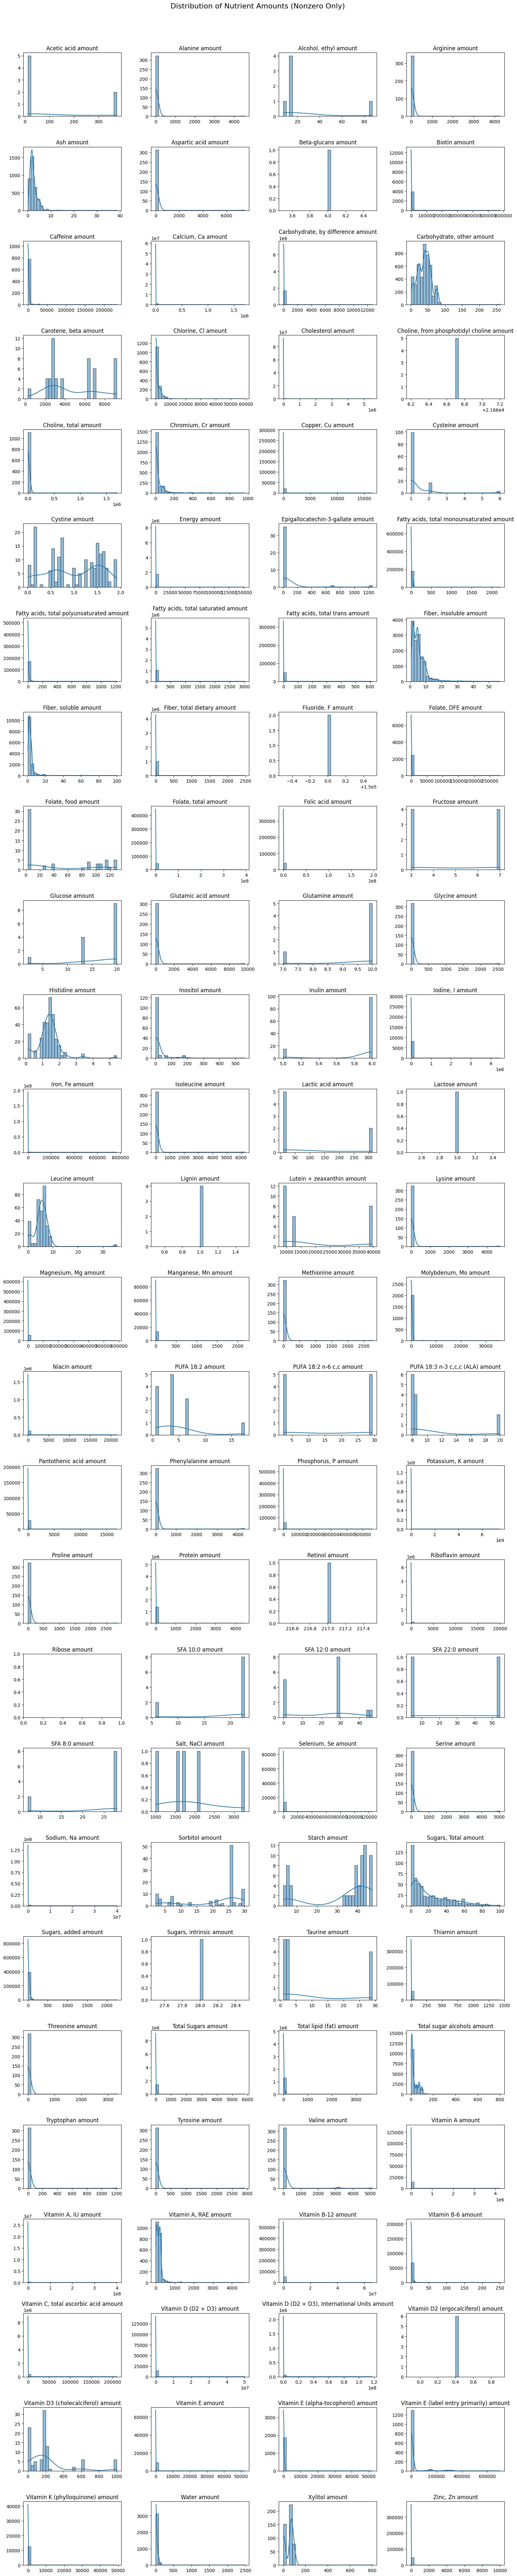

In [ ]:
# Numeric features: nutrient amounts (excluding zeros), shown in a grid
numeric_cols = [col for col in final_food_data.columns if 'amount' in col]
n = len(numeric_cols)
ncols = 4
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = final_food_data[final_food_data[col] > 0][col]
    if not data.empty:
        sns.histplot(data, bins=30, kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle('Distribution of Nutrient Amounts (Nonzero Only)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

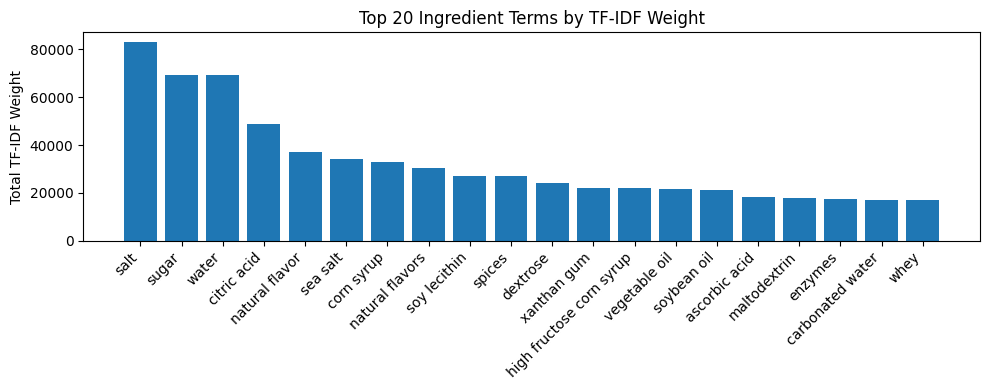

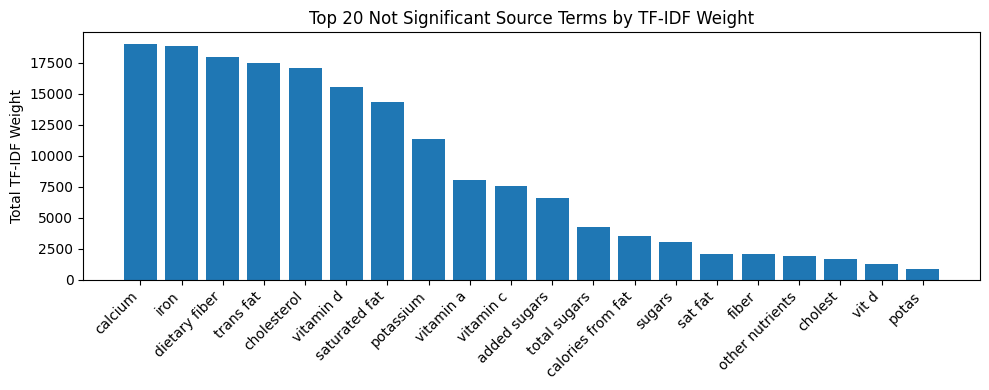

In [32]:
# Plot the sum of TF-IDF weights for each ingredient and not significant source term (top 20)
ingredient_terms = np.array(ingredient_vectorizer.get_feature_names_out())
ingredient_sums = np.asarray(ingredient_embeddings.sum(axis=0)).flatten()
top_ingredient_idx = ingredient_sums.argsort()[::-1][:20]
plt.figure(figsize=(10, 4))
plt.bar(ingredient_terms[top_ingredient_idx], ingredient_sums[top_ingredient_idx])
plt.title('Top 20 Ingredient Terms by TF-IDF Weight')
plt.ylabel('Total TF-IDF Weight')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

not_significant_terms = np.array(not_significant_vectorizer.get_feature_names_out())
not_significant_sums = np.asarray(not_significant_embeddings.sum(axis=0)).flatten()
top_not_significant_idx = not_significant_sums.argsort()[::-1][:20]
plt.figure(figsize=(10, 4))
plt.bar(not_significant_terms[top_not_significant_idx], not_significant_sums[top_not_significant_idx])
plt.title('Top 20 Not Significant Source Terms by TF-IDF Weight')
plt.ylabel('Total TF-IDF Weight')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

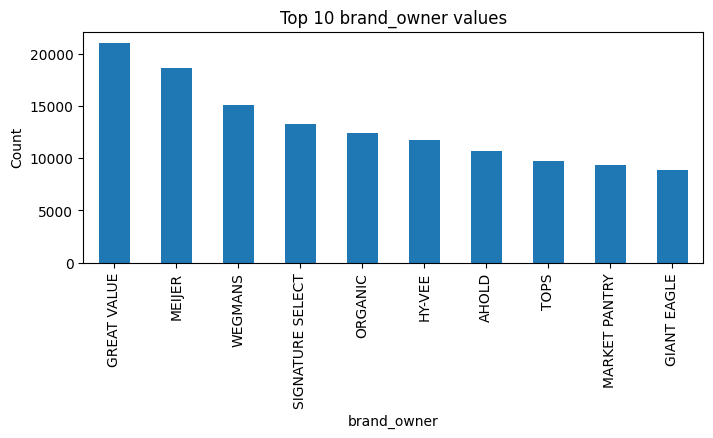

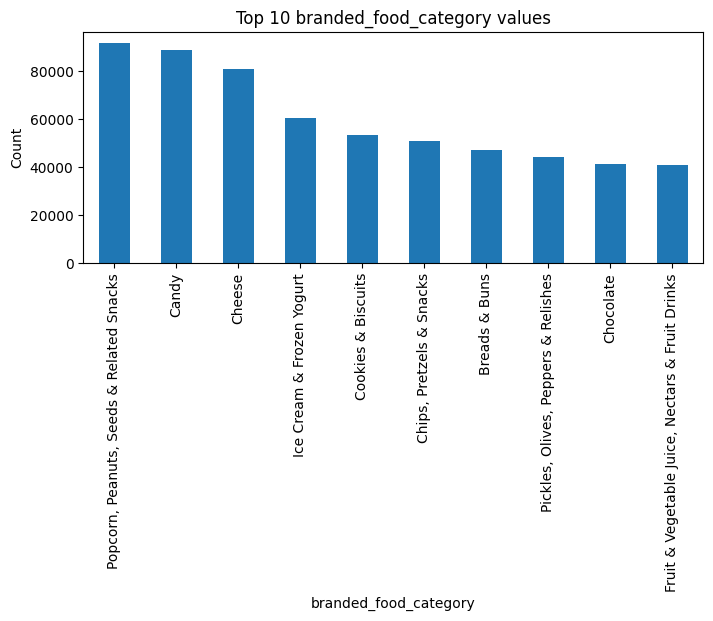

In [33]:
# Categorical features: brand_owner, branded_food_category
for col in ['brand_owner', 'branded_food_category']:
    if col in final_food_data.columns:
        value_counts = final_food_data[final_food_data[col] != 'None'][col].value_counts().head(10)
        plt.figure(figsize=(8, 3))
        value_counts.plot(kind='bar')
        plt.title(f'Top 10 {col} values')
        plt.ylabel('Count')
        plt.show()

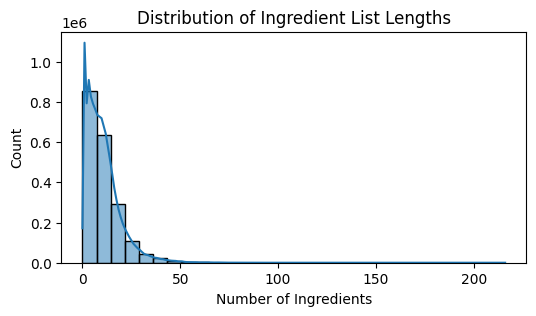

In [34]:
# Ingredients: Length of ingredient lists
final_food_data['ingredient_count'] = final_food_data['parsed_ingredients'].apply(len)
final_food_data['not_significant_count'] = final_food_data['parsed_not_significant'].apply(len)

plt.figure(figsize=(6, 3))
sns.histplot(final_food_data['ingredient_count'], bins=30, kde=True)
plt.title('Distribution of Ingredient List Lengths')
plt.xlabel('Number of Ingredients')
plt.ylabel('Count')
plt.show()

### Bivariate Analysis
Bivariate analysis examines the relationships and correlations between features.

First, let's create a correlation heatmap for all of the nutrient amount to see which ones are highly correlated. We will also print the top 5 most corrlated pairs.

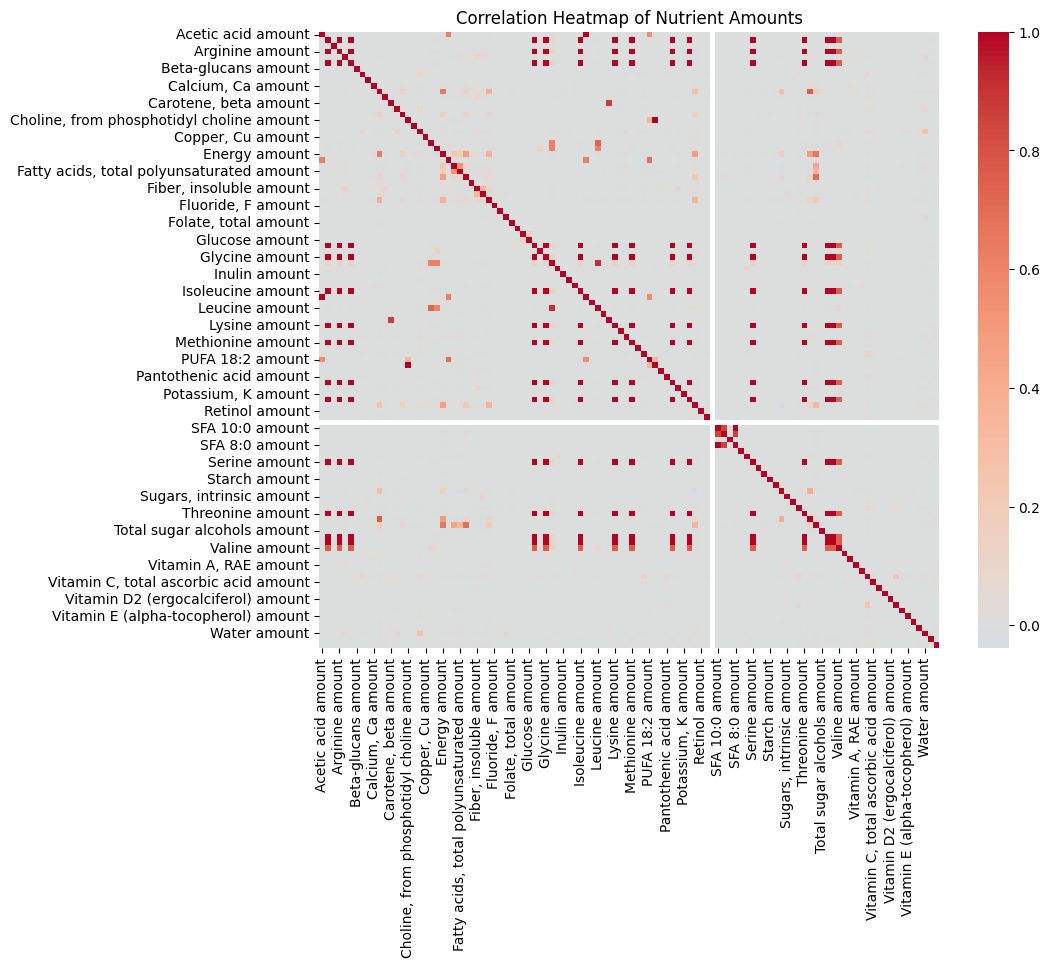

Top 5 Correlated Nutrient Pairs:
Lactic acid amount  Acetic acid amount      1.000000
Serine amount       Alanine amount          0.999999
Isoleucine amount   Methionine amount       0.999998
                    Alanine amount          0.999998
Serine amount       Phenylalanine amount    0.999998
dtype: float64


In [35]:
# Correlation heatmap for numeric features (nutrient amounts)
corr = final_food_data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Nutrient Amounts')
plt.show()

# Top 5 correlated nutrient pairs (absolute correlation)
corr_pairs = corr.abs().unstack().sort_values(ascending=False)
top_pairs = corr_pairs[corr_pairs < 1].drop_duplicates().head(5)
print("Top 5 Correlated Nutrient Pairs:")
print(top_pairs)

Next, we will examine the relation between nutrition and ingredients. For simplicity, we have only done correlations between the count of list items, or chose protein to compare with all list values.

In [ ]:
# Correlation between ingredient count and each nutrient
ingredient_count_corr = {col: final_food_data[col].corr(final_food_data['ingredient_count']) for col in numeric_cols}
print("\nCorrelation between ingredient count and each nutrient:")
print(pd.Series(ingredient_count_corr).sort_values(key=abs, ascending=False))

# Correlation between not significant count and each nutrient
not_significant_count_corr = {col: final_food_data[col].corr(final_food_data['not_significant_count']) for col in numeric_cols}
print("\nCorrelation between not significant source count and each nutrient:")
print(pd.Series(not_significant_count_corr).sort_values(key=abs, ascending=False))

def filter_constant_columns(df):
    return df.loc[:, df.std(axis=0, skipna=True) > 0]

top_n = 100
if 'protein amount' in [c.lower() for c in numeric_cols]:
    protein_col = [c for c in numeric_cols if c.lower() == 'protein amount'][0]
    # Top ingredient terms
    ingredient_terms = np.array(ingredient_vectorizer.get_feature_names_out())
    ingredient_sums = np.asarray(ingredient_embeddings.sum(axis=0)).flatten()
    top_ingredient_idx = ingredient_sums.argsort()[::-1][:top_n]
    ingredient_df = pd.DataFrame(ingredient_embeddings[:, top_ingredient_idx].toarray(), columns=ingredient_terms[top_ingredient_idx])
    ingredient_df = filter_constant_columns(ingredient_df)
    # Avoid division by zero in correlation by checking for constant columns
    if not ingredient_df.empty:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            ingredient_corr = ingredient_df.corrwith(final_food_data[protein_col])
        print("\nTop 10 ingredient TF-IDF features correlated with Protein amount:")
        print(ingredient_corr.abs().sort_values(ascending=False).head(10))
    else:
        print("No variable ingredient TF-IDF features to correlate.")

    # Top not significant source terms
    not_significant_terms = np.array(not_significant_vectorizer.get_feature_names_out())
    not_significant_sums = np.asarray(not_significant_embeddings.sum(axis=0)).flatten()
    top_not_significant_idx = not_significant_sums.argsort()[::-1][:top_n]
    not_significant_df = pd.DataFrame(not_significant_embeddings[:, top_not_significant_idx].toarray(), columns=not_significant_terms[top_not_significant_idx])
    not_significant_df = filter_constant_columns(not_significant_df)
    if not not_significant_df.empty:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            not_significant_corr = not_significant_df.corrwith(final_food_data[protein_col])
        print("\nTop 10 not significant source TF-IDF features correlated with Protein amount:")
        print(not_significant_corr.abs().sort_values(ascending=False).head(10))
    else:
        print("No variable not significant TF-IDF features to correlate.")


Correlation between ingredient count and each nutrient:
Carbohydrate, by difference amount    0.092833
Sugars, added amount                  0.090309
Total Sugars amount                   0.052512
Carbohydrate, other amount            0.047972
Vitamin B-6 amount                    0.043439
                                        ...   
Glutamine amount                     -0.000052
Retinol amount                       -0.000050
Lactose amount                        0.000031
Glucose amount                       -0.000020
Ribose amount                              NaN
Length: 108, dtype: float64

Correlation between not significant source count and each nutrient:
Protein amount                                    -0.056506
Sugars, added amount                               0.053047
Fiber, total dietary amount                       -0.046236
Energy amount                                     -0.039372
Vitamin B-6 amount                                 0.033265
                             

Now a bivariate analysis to show the nutrient means by branded food category.

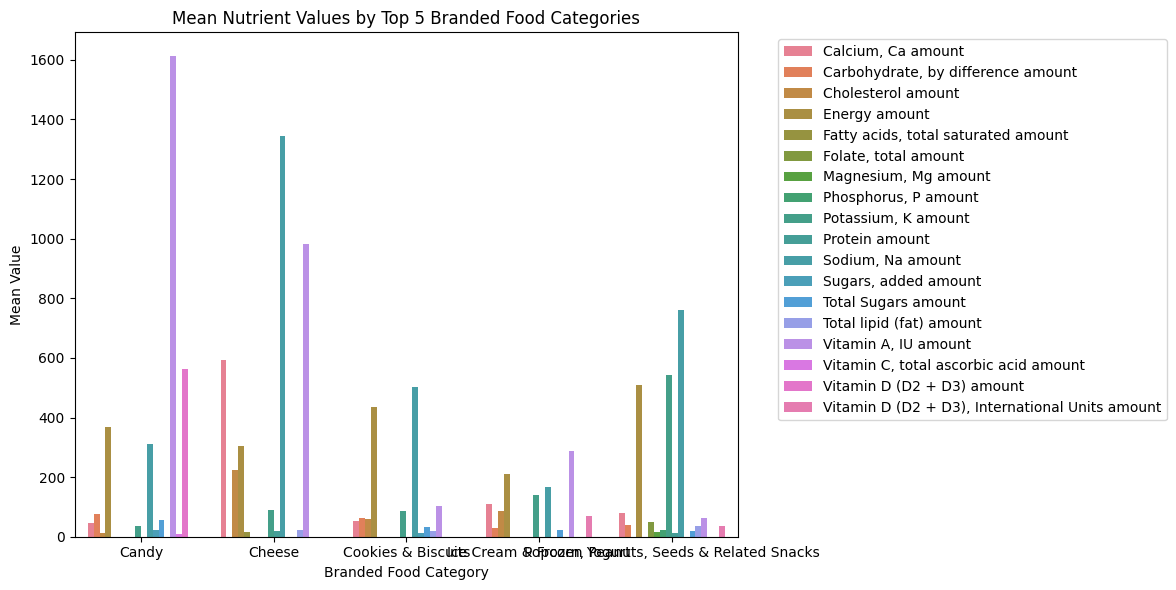

In [ ]:
# Grouped barplot: mean nutrient values by branded_food_category (top 5 categories by count)
if 'branded_food_category' in final_food_data.columns:
    top_categories = final_food_data['branded_food_category'].value_counts().head(5).index
    group_means = final_food_data[final_food_data['branded_food_category'].isin(top_categories)].groupby('branded_food_category')[numeric_cols].mean()
    group_means = group_means.loc[:, (group_means != 0).any(axis=0)]
    # Hide nutrient values under a certain level (e.g., 10)
    group_means = group_means.applymap(lambda x: x if x >= 10 else 0)
    group_means = group_means.loc[:, (group_means != 0).any(axis=0)]
    group_means_melted = group_means.reset_index().melt(id_vars='branded_food_category', var_name='Nutrient', value_name='Mean Value')
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=group_means_melted, x='branded_food_category', y='Mean Value', hue='Nutrient')
    handles, labels = barplot.get_legend_handles_labels()
    shown_labels = set(group_means_melted['Nutrient'].unique())
    filtered = [(h, l) for h, l in zip(handles, labels) if l in shown_labels]
    if filtered:
        handles, labels = zip(*filtered)
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend([], [], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Mean Nutrient Values by Top 5 Branded Food Categories')
    plt.ylabel('Mean Value')
    plt.xlabel('Branded Food Category')
    plt.tight_layout()
    plt.show()

An analysis of brand owner and ingredient count.

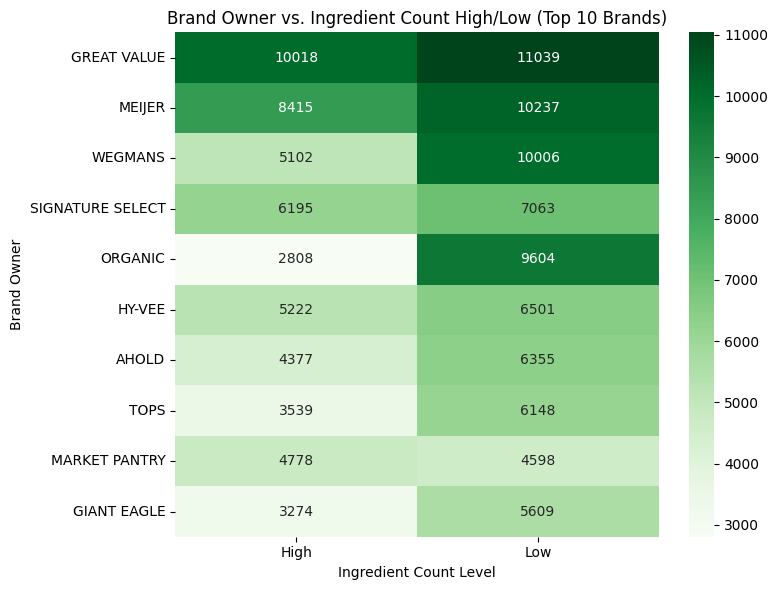

In [ ]:
# Cross-tabulation heatmap: brand_owner vs. high/low ingredient count (median split)
if 'brand_owner' in final_food_data.columns:
    median_ingredient_count = final_food_data['ingredient_count'].median()
    final_food_data['ingredient_count_high'] = (final_food_data['ingredient_count'] > median_ingredient_count).map({True: 'High', False: 'Low'})
    filtered_brand_data = final_food_data[final_food_data['brand_owner'] != 'None']
    ctab2 = pd.crosstab(filtered_brand_data['brand_owner'], filtered_brand_data['ingredient_count_high'])
    top_brands = ctab2.sum(axis=1).sort_values(ascending=False).head(10).index
    plt.figure(figsize=(8, 6))
    sns.heatmap(ctab2.loc[top_brands], annot=True, fmt='d', cmap='Greens')
    plt.title('Brand Owner vs. Ingredient Count High/Low (Top 10 Brands)')
    plt.ylabel('Brand Owner')
    plt.xlabel('Ingredient Count Level')
    plt.tight_layout()
    plt.show()

Finally, a bar plot of mean ingredient count per branded food category.

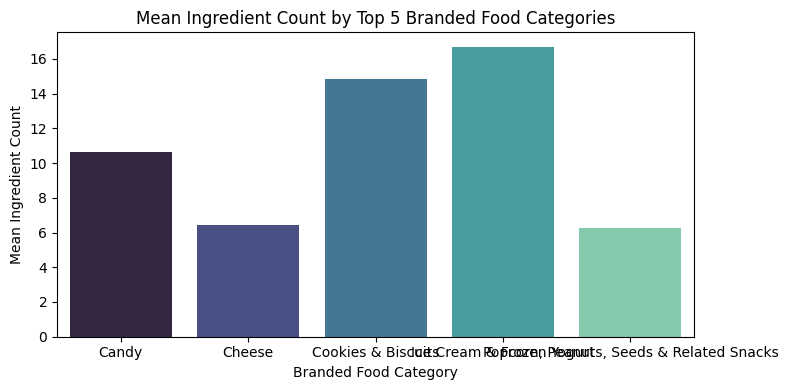

In [39]:
# Barplot: mean ingredient count by branded_food_category (top 5 categories)
if 'branded_food_category' in final_food_data.columns:
    group_ingredient_count = final_food_data[final_food_data['branded_food_category'].isin(top_categories)].groupby('branded_food_category')['ingredient_count'].mean().reset_index()
    plt.figure(figsize=(8, 4))
    sns.barplot(data=group_ingredient_count, x='branded_food_category', y='ingredient_count', palette='mako')
    plt.title('Mean Ingredient Count by Top 5 Branded Food Categories')
    plt.ylabel('Mean Ingredient Count')
    plt.xlabel('Branded Food Category')
    plt.tight_layout()
    plt.show()

### Outlier Detection
Now that we have analyzed some of the feature distributions and correlations, we can start to observe potential outliers in the dataset.

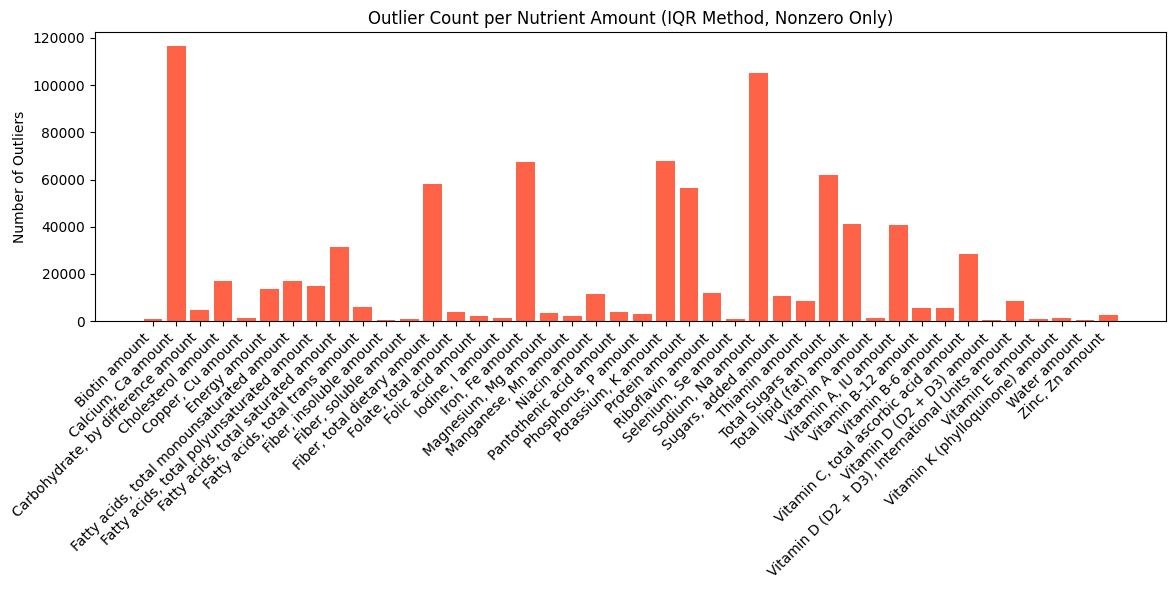

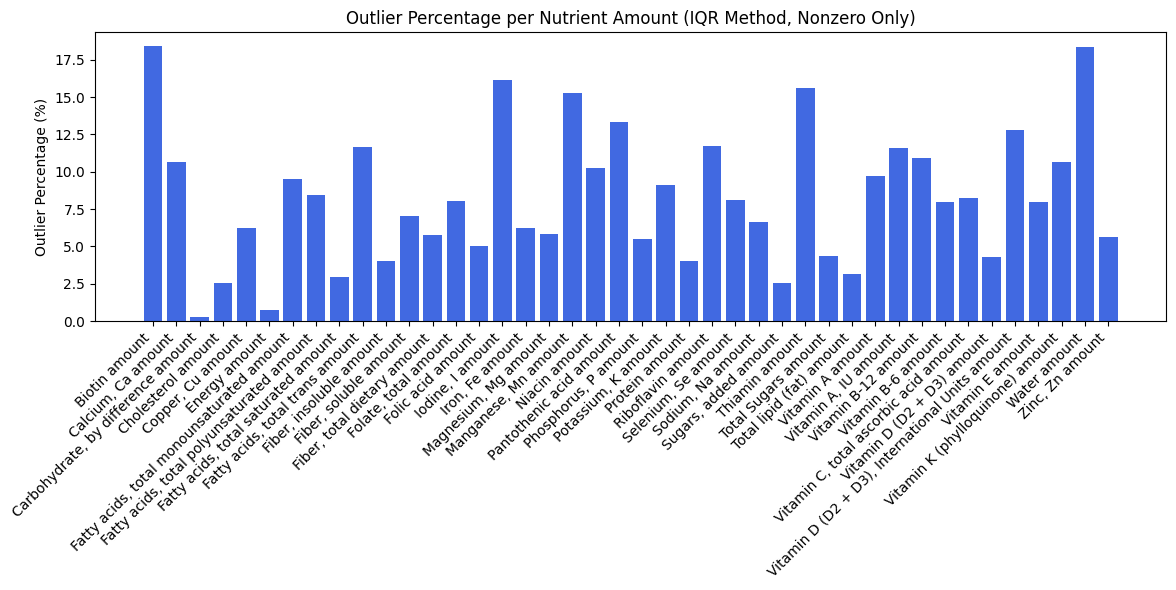

,Nutrient,Outlier_Count,Total,Outlier_Percentage
9,"Calcium, Ca amount",116560,1097174,10.623657
76,"Sodium, Na amount",105018,1587959,6.613395
63,"Potassium, K amount",67948,747386,9.091420
44,"Iron, Fe amount",67533,1083583,6.232379
85,Total Sugars amount,61974,1427690,4.340858
29,"Fiber, total dietary amount",58114,1010360,5.751811
65,Protein amount,56236,1407063,3.996694
86,Total lipid (fat) amount,41199,1304496,3.158231
92,"Vitamin A, IU amount",40810,351338,11.615595
25,"Fatty acids, total saturated amount",31388,1051587,2.984822


In [ ]:
# Outlier Detection for Nutrient Amounts
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

# Find all nutrient amount columns
detected_outliers = {}
outlier_counts = []
for col in numeric_cols:
    # Only consider nonzero values for outlier detection
    nonzero = final_food_data[col][final_food_data[col] > 0]
    if not nonzero.empty:
        outliers = detect_outliers_iqr(nonzero)
        detected_outliers[col] = outliers
        outlier_counts.append({'Nutrient': col, 'Outlier_Count': outliers.sum(), 'Total': len(nonzero)})
    else:
        outlier_counts.append({'Nutrient': col, 'Outlier_Count': 0, 'Total': 0})

outlier_df = pd.DataFrame(outlier_counts)
outlier_df['Outlier_Percentage'] = (outlier_df['Outlier_Count'] / outlier_df['Total']).fillna(0) * 100

# Filter out nutrients with very low outliers for plots (to be perceptible)
outlier_df_nonzero = outlier_df[outlier_df['Outlier_Count'] > 500]

# Visualize the number and percentage of outliers for each nutrient (filtered)
plt.figure(figsize=(12, 6))
plt.bar(outlier_df_nonzero['Nutrient'], outlier_df_nonzero['Outlier_Count'], color='tomato', label='Outlier Count')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45, ha='right')
plt.title('Outlier Count per Nutrient Amount (IQR Method, Nonzero Only)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(outlier_df_nonzero['Nutrient'], outlier_df_nonzero['Outlier_Percentage'], color='royalblue', label='Outlier %')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Outlier Percentage per Nutrient Amount (IQR Method, Nonzero Only)')
plt.tight_layout()
plt.show()

# Show the top 10 nutrients with the highest outlier count (table)
outlier_df_nonzero.sort_values('Outlier_Count', ascending=False).head(10)

Ingredient count outliers: 74378 out of 1977398 (3.76%)
Not significant source count outliers: 79593 out of 1977398 (4.03%)


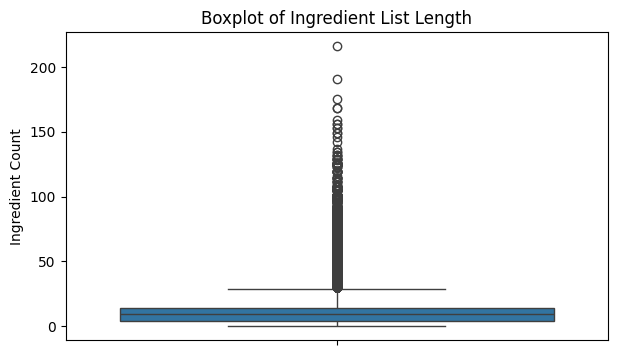

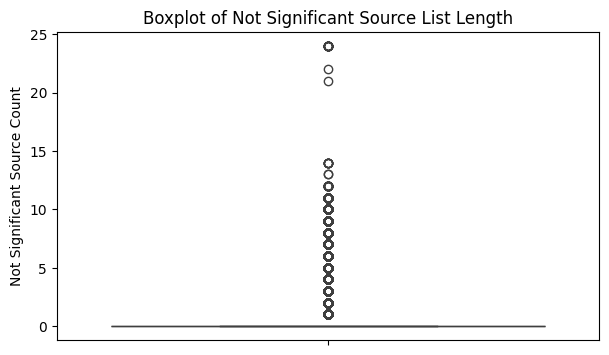

In [41]:
# Outlier Detection and Separate Boxplots for Ingredient and Not Significant Source Lengths (with Outlier Percentage)

def detect_outliers_iqr_series(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

# Outlier detection for ingredient_count and not_significant_count
ingredient_outliers = detect_outliers_iqr_series(final_food_data['ingredient_count'])
not_significant_outliers = detect_outliers_iqr_series(final_food_data['not_significant_count'])

ingredient_outlier_pct = 100 * ingredient_outliers.sum() / len(ingredient_outliers)
not_significant_outlier_pct = 100 * not_significant_outliers.sum() / len(not_significant_outliers)

print(f"Ingredient count outliers: {ingredient_outliers.sum()} out of {len(ingredient_outliers)} ({ingredient_outlier_pct:.2f}%)")
print(f"Not significant source count outliers: {not_significant_outliers.sum()} out of {len(not_significant_outliers)} ({not_significant_outlier_pct:.2f}%)")

plt.figure(figsize=(7, 4))
sns.boxplot(y=final_food_data['ingredient_count'])
plt.title('Boxplot of Ingredient List Length')
plt.ylabel('Ingredient Count')
plt.show()

plt.figure(figsize=(7, 4))
sns.boxplot(y=final_food_data['not_significant_count'])
plt.title('Boxplot of Not Significant Source List Length')
plt.ylabel('Not Significant Source Count')
plt.show()

## Step 2: Feature Engineering

### Feature Transformation
Feature transformation involves adding more columns to the dataset by modifying already existing columns. This was already done with ingredients and not_a_significant_source_of when we added embeddings for those features. Now we will add a log transform for nutrient amounts.

In [47]:
# Efficient log transform for all skewed columns
embedding_prefixes = [f'ingredient_emb_', f'not_significant_emb_']
def is_embedding_col(col):
    return any(col.startswith(prefix) for prefix in embedding_prefixes)

# Filter numeric columns to exclude embedding columns
numeric_cols_no_emb = [col for col in numeric_cols if not is_embedding_col(col)]
skewed_cols = [col for col in numeric_cols_no_emb if abs(final_food_data[col].skew()) > 1]

# Remove any previously added log columns to avoid duplication on re-execution
log_cols_to_remove = [col for col in final_food_data.columns if col.endswith('_log') and col.replace('_log', '') in numeric_cols_no_emb]
if log_cols_to_remove:
    final_food_data.drop(columns=log_cols_to_remove, inplace=True)
log_transformed = {}
for col in skewed_cols:
    log_transformed[f'{col}_log'] = np.where(final_food_data[col] > 0, np.log1p(final_food_data[col]), 0)
if log_transformed:
    final_food_data = pd.concat([final_food_data, pd.DataFrame(log_transformed, index=final_food_data.index)], axis=1)

print(f"Log-transformed columns: {skewed_cols}")

Log-transformed columns: ['Acetic acid amount', 'Alanine amount', 'Alcohol, ethyl amount', 'Arginine amount', 'Ash amount', 'Aspartic acid amount', 'Beta-glucans amount', 'Biotin amount', 'Caffeine amount', 'Calcium, Ca amount', 'Carbohydrate, by difference amount', 'Carbohydrate, other amount', 'Carotene, beta amount', 'Chlorine, Cl amount', 'Cholesterol amount', 'Choline, from phosphotidyl choline amount', 'Choline, total amount', 'Chromium, Cr amount', 'Copper, Cu amount', 'Cysteine amount', 'Cystine amount', 'Energy amount', 'Epigallocatechin-3-gallate amount', 'Fatty acids, total monounsaturated amount', 'Fatty acids, total polyunsaturated amount', 'Fatty acids, total saturated amount', 'Fatty acids, total trans amount', 'Fiber, insoluble amount', 'Fiber, soluble amount', 'Fiber, total dietary amount', 'Fluoride, F amount', 'Folate, DFE amount', 'Folate, food amount', 'Folate, total amount', 'Folic acid amount', 'Fructose amount', 'Glucose amount', 'Glutamic acid amount', 'Glutami

### Feature Encoding
Categorical features need to be encoded into numerical values for efficient use in the model. For this, we can use a label encoder for columns like brand_owner, branded_food_category, and serving_size_unit.

We also want to one-hot encode the ingredient list which indicates whether or not that ingredient is present. In our model, any number of these columns will be our target to predict. Ex: predict if this food item has salt.

In [ ]:
# Encode categorical features using LabelEncoder
categorical_cols = ['brand_owner', 'branded_food_category', 'serving_size_unit']
label_encoders = {}
for col in categorical_cols:
    if col in final_food_data.columns:
        le = LabelEncoder()
        final_food_data[f'{col}_encoded'] = le.fit_transform(final_food_data[col])
        label_encoders[col] = le

print("Encoded columns:", [f'{col}_encoded' for col in categorical_cols if col in final_food_data.columns])

# Remove any previously added one-hot columns to avoid duplication on re-execution
ingredient_onehot_cols = [col for col in final_food_data.columns if col.startswith('ingredient_oh_')]
if ingredient_onehot_cols:
    final_food_data.drop(columns=ingredient_onehot_cols, inplace=True)

# Join ingredient lists into strings for vectorization
ingredient_strings = final_food_data['parsed_ingredients'].apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Use CountVectorizer with binary=True and max_features to limit memory usage
max_oh_features = 100  # Adjust as needed for memory constraints
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), binary=True, max_features=max_oh_features)
ingredient_onehot_sparse = vectorizer.fit_transform(ingredient_strings)
ingredient_onehot_df = pd.DataFrame(ingredient_onehot_sparse.toarray(), columns=[f'ingredient_oh_{c}' for c in vectorizer.get_feature_names_out()], index=final_food_data.index)

# Add one-hot columns to DataFrame
for col in ingredient_onehot_df.columns:
    final_food_data[col] = ingredient_onehot_df[col]

print(f"Added {ingredient_onehot_df.shape[1]} one-hot ingredient columns (top {max_oh_features} by frequency).")

Encoded columns: ['brand_owner_encoded', 'branded_food_category_encoded', 'serving_size_unit_encoded']
Added 100 one-hot ingredient columns (top 100 by frequency).
Added 100 one-hot ingredient columns (top 100 by frequency).


### Feature Scaling
Now we will perform feature scaling on all numeric columns using StandardScaler. This is because some models are sensitive to some features being higher scaled than others.

In [ ]:
# Scale numeric features using StandardScaler
scaler = StandardScaler()

# Select columns to scale: all nutrient amounts, log-transformed, ingredient/not_significant counts
scale_cols = numeric_cols + [f'{col}_log' for col in skewed_cols] + ['ingredient_count', 'not_significant_count']
scale_cols = [col for col in scale_cols if col in final_food_data.columns]

final_food_data_scaled = final_food_data.copy()
final_food_data_scaled[scale_cols] = scaler.fit_transform(final_food_data[scale_cols])

print("Scaled columns:", scale_cols)

Scaled columns: ['Acetic acid amount', 'Alanine amount', 'Alcohol, ethyl amount', 'Arginine amount', 'Ash amount', 'Aspartic acid amount', 'Beta-glucans amount', 'Biotin amount', 'Caffeine amount', 'Calcium, Ca amount', 'Carbohydrate, by difference amount', 'Carbohydrate, other amount', 'Carotene, beta amount', 'Chlorine, Cl amount', 'Cholesterol amount', 'Choline, from phosphotidyl choline amount', 'Choline, total amount', 'Chromium, Cr amount', 'Copper, Cu amount', 'Cysteine amount', 'Cystine amount', 'Energy amount', 'Epigallocatechin-3-gallate amount', 'Fatty acids, total monounsaturated amount', 'Fatty acids, total polyunsaturated amount', 'Fatty acids, total saturated amount', 'Fatty acids, total trans amount', 'Fiber, insoluble amount', 'Fiber, soluble amount', 'Fiber, total dietary amount', 'Fluoride, F amount', 'Folate, DFE amount', 'Folate, food amount', 'Folate, total amount', 'Folic acid amount', 'Fructose amount', 'Glucose amount', 'Glutamic acid amount', 'Glutamine amount

### Normalization
Finally we will perform normalization, which is used alongisde scaling to constrict the range of the scaled features to [0,1]

In [51]:
# Normalize scaled features to [0, 1] range using MinMaxScaler
minmax_scaler = MinMaxScaler()
final_food_data_normalized = final_food_data_scaled.copy()
final_food_data_normalized[scale_cols] = minmax_scaler.fit_transform(final_food_data_scaled[scale_cols])

print("Normalized columns:", scale_cols)
final_food_data_normalized.head()

Normalized columns: ['Acetic acid amount', 'Alanine amount', 'Alcohol, ethyl amount', 'Arginine amount', 'Ash amount', 'Aspartic acid amount', 'Beta-glucans amount', 'Biotin amount', 'Caffeine amount', 'Calcium, Ca amount', 'Carbohydrate, by difference amount', 'Carbohydrate, other amount', 'Carotene, beta amount', 'Chlorine, Cl amount', 'Cholesterol amount', 'Choline, from phosphotidyl choline amount', 'Choline, total amount', 'Chromium, Cr amount', 'Copper, Cu amount', 'Cysteine amount', 'Cystine amount', 'Energy amount', 'Epigallocatechin-3-gallate amount', 'Fatty acids, total monounsaturated amount', 'Fatty acids, total polyunsaturated amount', 'Fatty acids, total saturated amount', 'Fatty acids, total trans amount', 'Fiber, insoluble amount', 'Fiber, soluble amount', 'Fiber, total dietary amount', 'Fluoride, F amount', 'Folate, DFE amount', 'Folate, food amount', 'Folate, total amount', 'Folic acid amount', 'Fructose amount', 'Glucose amount', 'Glutamic acid amount', 'Glutamine am

,fdc_id,description,brand_owner,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,branded_food_category,Acetic acid amount,Alanine amount,"Alcohol, ethyl amount",Arginine amount,Ash amount,Aspartic acid amount,Beta-glucans amount,Biotin amount,Caffeine amount,"Calcium, Ca amount","Carbohydrate, by difference amount","Carbohydrate, other amount","Carotene, beta amount","Chlorine, Cl amount",Cholesterol amount,"Choline, from phosphotidyl choline amount","Choline, total amount","Chromium, Cr amount","Copper, Cu amount",Cysteine amount,Cystine amount,Energy amount,Epigallocatechin-3-gallate amount,"Fatty acids, total monounsaturated amount","Fatty acids, total polyunsaturated amount","Fatty acids, total saturated amount","Fatty acids, total trans amount","Fiber, insoluble amount","Fiber, soluble amount","Fiber, total dietary amount","Fluoride, F amount","Folate, DFE amount","Folate, food amount","Folate, total amount",Folic acid amount,Fructose amount,Glucose amount,Glutamic acid amount,Glutamine amount,Glycine amount,Histidine amount,Inositol amount,Inulin amount,"Iodine, I amount","Iron, Fe amount",Isoleucine amount,Lactic acid amount,Lactose amount,Leucine amount,Lignin amount,Lutein + zeaxanthin amount,Lysine amount,"Magnesium, Mg amount","Manganese, Mn amount",Methionine amount,"Molybdenum, Mo amount",Niacin amount,PUFA 18:2 amount,"PUFA 18:2 n-6 c,c amount","PUFA 18:3 n-3 c,c,c (ALA) amount",Pantothenic acid amount,Phenylalanine amount,"Phosphorus, P amount","Potassium, K amount",Proline amount,Protein amount,Retinol amount,Riboflavin amount,Ribose amount,SFA 10:0 amount,SFA 12:0 amount,SFA 22:0 amount,SFA 8:0 amount,"Salt, NaCl amount","Selenium, Se amount",Serine amount,"Sodium, Na amount",Sorbitol amount,Starch amount,"Sugars, Total amount","Sugars, added amount","Sugars, intrinsic amount",Taurine amount,Thiamin amount,Threonine amount,Total Sugars amount,Total lipid (fat) amount,Total sugar alcohols amount,Tryptophan amount,Tyrosine amount,Valine amount,Vitamin A amount,"Vitamin A, IU amount","Vitamin A, RAE amount",Vitamin B-12 amount,Vitamin B-6 amount,"Vitamin C, total ascorbic acid amount",Vitamin D (D2 + D3) amount,"Vitamin D (D2 + D3), International Units amount",Vitamin D2 (ergocalciferol) amount,Vitamin D3 (cholecalciferol) amount,Vitamin E amount,Vitamin E (alpha-tocopherol) amount,Vitamin E (label entry primarily) amount,Vitamin K (phylloquinone) amount,Water amount,Xylitol amount,"Zinc, Zn amount",Acetic acid unit,Alanine unit,"Alcohol, ethyl unit",Arginine unit,Ash unit,Aspartic acid unit,Beta-glucans unit,Biotin unit,Caffeine unit,"Calcium, Ca unit","Carbohydrate, by difference unit","Carbohydrate, other unit","Carotene, beta unit","Chlorine, Cl unit",Cholesterol unit,"Choline, from phosphotidyl choline unit","Choline, total unit","Chromium, Cr unit","Copper, Cu unit",Cysteine unit,Cystine unit,Energy unit,Epigallocatechin-3-gallate unit,"Fatty acids, total monounsaturated unit","Fatty acids, total polyunsaturated unit","Fatty acids, total saturated unit","Fatty acids, total trans unit","Fiber, insoluble unit","Fiber, soluble unit","Fiber, total dietary unit","Fluoride, F unit","Folate, DFE unit","Folate, food unit","Folate, total unit",Folic acid unit,Fructose unit,Glucose unit,Glutamic acid unit,Glutamine unit,Glycine unit,Histidine unit,Inositol unit,Inulin unit,"Iodine, I unit","Iron, Fe unit",Isoleucine unit,Lactic acid unit,Lactose unit,Leucine unit,Lignin unit,Lutein + zeaxanthin unit,Lysine unit,"Magnesium, Mg unit","Manganese, Mn unit",Methionine unit,"Molybdenum, Mo unit",Niacin unit,PUFA 18:2 unit,"PUFA 18:2 n-6 c,c unit","PUFA 18:3 n-3 c,c,c (ALA) unit",Pantothenic acid unit,Phenylalanine unit,"Phosphorus, P unit","Potassium, K unit",Proline unit,Protein unit,Retinol unit,Riboflavin unit,Ribose unit,SFA 10:0 unit,SFA 12:0 unit,SFA 22:0 unit,SFA 8:0 unit,"Salt, NaCl unit","Selenium, Se unit",Serine unit,"Sodium, Na unit",Sorbitol unit,Starch unit,"Sugars, Total unit","Sugars, 

#### TODO
- Accurately merge brand name and subbrand to brand owner
- Attempt to merge some ingredients and notsigsources before embedding (find all with substrings of another)
- Move the feature selection: dropping of irrelevant features to feature engineering (after analysis steps) so we can use correlation to drive decision
- Use description feature in some way (desc length?)
- Standardize nutrient amounts
- Shorten graph names by character amount
- Make sure feature scaling scales all numeric columns
- More ‘Feature Extraction’ getting features from other features
